In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torch
import numpy as np
from torch.autograd import Variable 


In [2]:
mobi_data = pd.read_csv("../data/Mobi_System_Data_2020.csv", compression='zip').dropna()
geo_data = pd.read_csv('../data/geocodings.csv',index_col=0)
data = mobi_data.merge(geo_data.rename({'lat':'Departure lat','long':'Departure long'},axis=1),left_on='Departure station',right_on='address').drop('address',axis=1)
data = data.merge(geo_data.rename({'lat':'Return lat','long':'Return long'},axis=1),left_on='Return station',right_on='address').drop('address',axis=1)
data.shape
# data = data.loc[data["Departure postal code"].str.startswith("V6")]
print(data.columns)
data["time"] = pd.to_datetime(data["Departure"], format="%Y-%m-%d %H:%M:%S")
data["hour"] = data["time"].dt.hour
data["day"] = data["time"].dt.day
data["month"] = data["time"].dt.month
data["year"] = data["time"].dt.year



Index(['Unnamed: 0', 'Departure', 'Return', 'Bike', 'Departure station',
       'Return station', 'Membership type', 'Covered distance (m)',
       'Duration (sec.)', 'Departure battery voltage (mV)',
       'Return battery voltage (mV)', 'Departure temperature (C)',
       'Return temperature (C)', 'Stopover duration (sec.)',
       'Number of stopovers', 'postal_code_x', 'Departure lat',
       'Departure long', 'postal_code_y', 'Return lat', 'Return long'],
      dtype='object')


In [3]:
# Preprocess for stations
stations = data[["Departure lat", "Departure long", "Departure station", "postal_code_x"]].drop_duplicates()
stations = stations.rename(columns={"Departure lat": "lat", "Departure long": "long", "Departure station": "station", "postal_code_x": "postal_code"})
stations["postal_code"] = stations["postal_code"].str[0:3]
parks = pd.read_csv('../data/processed/parks.csv',index_col=0)
population = pd.read_csv("../data/processed/population.csv")
translink_stops = pd.read_csv("../data/processed/translink_stops.csv")
population = pd.read_csv("../data/processed/population.csv")

In [4]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r

In [25]:
import json
for s in stations.iterrows():
    lat, long = s[1][0], s[1][1]
    stations.loc[s[0], "is_park"] = 0
    for p in parks.iterrows():
        p_lat, p_long = p[1][0], p[1][1]
        distance = haversine(lat, long, p_lat, p_long)
        if distance < 0.5:
            stations.loc[s[0], "is_park"] = 1
            break
    stations.loc[s[0], "stops"] = 0
    for t in translink_stops.iterrows():
        t_lat, t_long = t[1][1], t[1][2]
        distance = haversine(lat, long, t_lat, t_long)
        if distance < 0.25:
            stations.loc[s[0], "stops"] += 1
    postal_code = s[1][3]
    search = population.loc[population["Geographic code"] == postal_code]
    if search.shape[0] > 0:
        stations.loc[s[0], "population"] = search.iloc[0, 2]
    else:
        stations.loc[s[0], "population"] = 0
max_p, min_p = stations["population"].max(), stations["population"].min()
stations["population"] = (stations["population"] - min_p) / (max_p - min_p)
stations["stops"] = stations["stops"] / stations["stops"].max()
max_lat, min_lat = stations["lat"].max(), stations["lat"].min()
max_long, min_long = stations["long"].max(), stations["long"].min()


In [53]:
def generate_time_df(start_time, peroid):
    predict_data = pd.DataFrame(data={
        "month": [], 
        "day": [], 
        "hour": [], 
        "lat": [],
        "long": [],
        "is_park": [],
        "stops": [],
        "population": [],
        "station": []})
    for row in stations.iterrows():
        time = pd.date_range(start_time, periods=peroid, freq='H')

        station_data = pd.DataFrame(data={"time": time})
        station_data["hour"] = station_data["time"].dt.hour
        station_data["day"] = station_data["time"].dt.day
        station_data["month"] = station_data["time"].dt.month
        station_data["lat"] = (row[1]["lat"] - min_lat) / (max_lat - min_lat)
        station_data["long"] = (row[1]["long"] - min_long) / (max_long - min_long)
        station_data["station"] = row[1]["station"]
        station_data["is_park"] = row[1]["is_park"]
        station_data["stops"] = row[1]["stops"]
        station_data["population"] = row[1]["population"]
        station_data = station_data.drop(columns=["time"])
        
        predict_data = pd.concat([predict_data, station_data])
    
    return predict_data


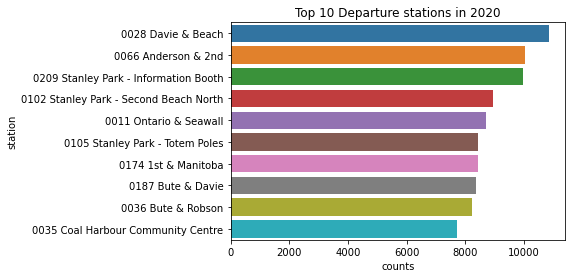

In [54]:
features_departure = ["month", "day", "hour", "lat", "long", "is_park", "stops", "population"]
counts_data_departure = data.groupby(["month", "day", "hour", "Departure lat", "Departure long", "Departure station"]).size().reset_index(name='counts')
counts_data_departure = counts_data_departure.rename(columns={"Departure lat": "lat", "Departure long": "long", "Departure station": "station"})

departure_time_df = generate_time_df('2020-01-01', 8760)

train_data = departure_time_df.merge(counts_data_departure[["month", "day", "hour", "station", "counts"]], how="left", left_on=["month", "day", "hour", "station"], right_on=["month", "day", "hour", "station"])
train_data["counts"] = train_data["counts"].fillna(0)

top_stations = train_data[["station", "counts"]].groupby("station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="station", data=top_stations)
ax.set(title='Top 10 Departure stations in 2020')

train_data["month"] = train_data["month"] / 12
train_data["day"] = train_data["day"] / 31
train_data["hour"] = train_data["hour"] / 23
x = train_data[features_departure]
y = train_data["counts"]
    



In [55]:
from xgboost import XGBRegressor
model_departure = XGBRegressor()
model_departure.fit(x, y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [56]:
predict_data_departure = generate_time_df('2022-05-01', 168)
predict_data_departure["month"] = predict_data_departure["month"] / 12
predict_data_departure["day"] = predict_data_departure["day"] / 31
predict_data_departure["hour"] = predict_data_departure["hour"] / 23
predict_data_departure["counts"] = model_departure.predict(predict_data_departure[features_departure])
predict_data_departure["counts"] = predict_data_departure["counts"].clip(lower=0.000001)
print(predict_data_departure["counts"].sum())

9386.538


<AxesSubplot:title={'center':'# of Departure for each hour'}, xlabel='hour'>

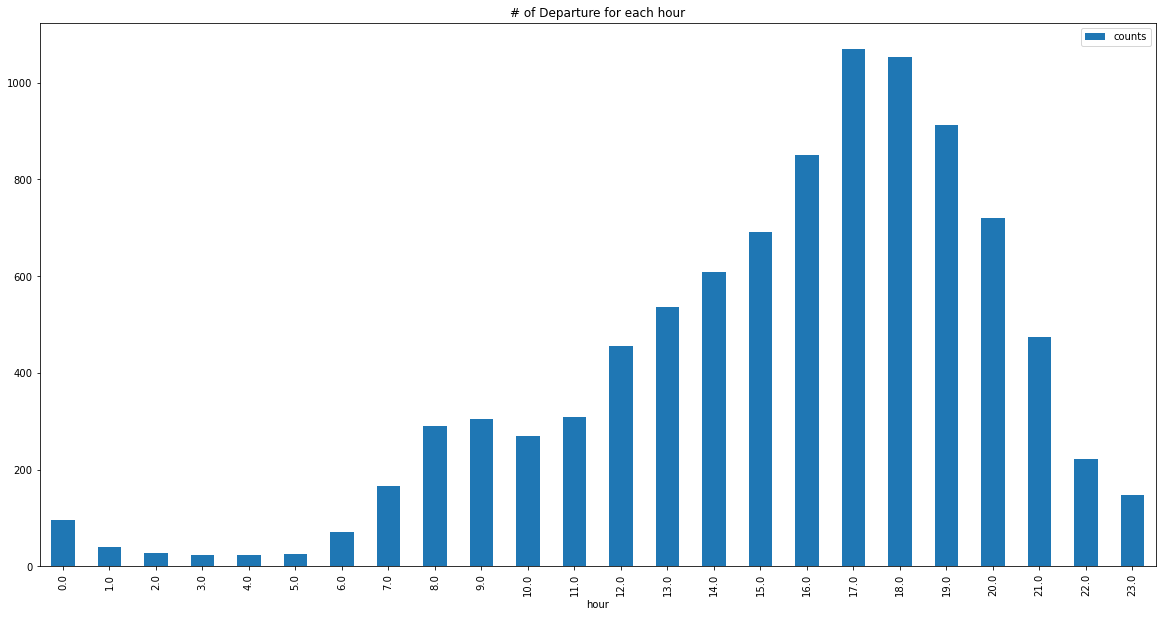

In [57]:
hours = predict_data_departure.loc[:, ["hour", "counts"]]
hours["hour"] = (hours["hour"] * 23).round()
hours = hours.groupby("hour").sum()
hours.plot(kind='bar', figsize=(20, 10), title="# of Departure for each hour")

In [47]:
# month = predict_data_departure.loc[:, ["month", "counts"]]
# month["month"] = (month["month"] * 12).round()
# month = month.groupby("month").sum()
# month.plot(kind='bar', figsize=(20, 10), title="# of Departure for each month");

[Text(0.5, 1.0, 'Top 10 departure stations')]

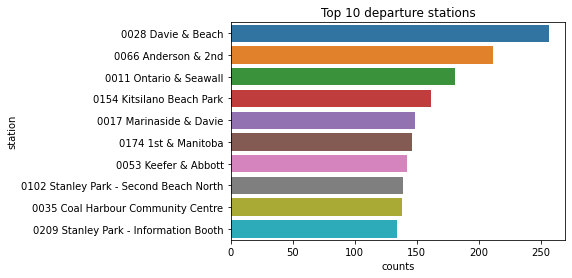

In [58]:
top_stations = predict_data_departure[["station", "counts"]].groupby("station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="station", data=top_stations)
ax.set(title="Top 10 departure stations")

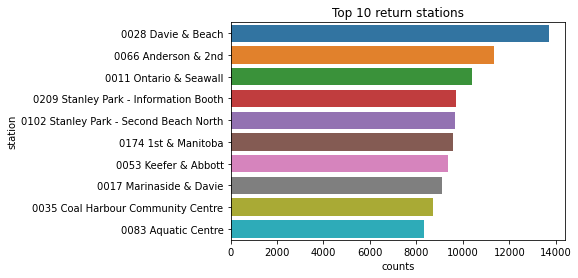

In [60]:
features_return = ["month", "day", "hour", "lat", "long", "is_park", "stops", "population"]
counts_data_return = data.loc[:, ["month", "day", "hour", "Return lat", "Return long", "Return station", "Duration (sec.)"]]
counts_data_return["Duration (sec.)"] = (counts_data_return["Duration (sec.)"] / 3600).astype(int)
counts_data_return["hour"] = counts_data_return["hour"] + counts_data_return["Duration (sec.)"]
counts_data_return["day"] = counts_data_return["day"] + (counts_data_return["hour"] / 24).astype(int)
counts_data_return["hour"] = counts_data_return["hour"].mod(24)
counts_data_return = counts_data_return.drop(columns=["Duration (sec.)"])
counts_data_return = counts_data_return.groupby(["month", "day", "hour", "Return lat", "Return long", "Return station"]).size().reset_index(name='counts')
counts_data_return = counts_data_return.rename(columns={"Return lat": "lat", "Return long": "long", "Return station": "station"})
return_time_df = generate_time_df('2020-01-01', 8760)
train_data = return_time_df.merge(counts_data_return[["month", "day", "hour", "station", "counts"]], how="left", on=["month", "day", "hour", "station"])
train_data["counts"] = train_data["counts"].fillna(0)

top_stations = train_data[["station", "counts"]].groupby("station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="station", data=top_stations)
ax.set(title='Top 10 return stations')

train_data["month"] = train_data["month"] / 12
train_data["day"] = train_data["day"] / 31
train_data["hour"] = train_data["hour"] / 23
x = train_data[features_return]
y = train_data["counts"]
    

In [61]:
from xgboost import XGBRegressor
model_return = XGBRegressor()
model_return.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [62]:
predict_data_return = generate_time_df('2022-05-01', 168)
predict_data_return["month"] = predict_data_return["month"] / 12
predict_data_return["day"] = predict_data_return["day"] / 31
predict_data_return["hour"] = predict_data_return["hour"] / 23
predict_data_return["counts"] = model_return.predict(predict_data_return[features_return])
predict_data_return["counts"] = predict_data_return["counts"].clip(lower=0.000001)
print(predict_data_return["counts"].sum())

9383.087


<AxesSubplot:title={'center':'# of Return for each hour'}, xlabel='hour'>

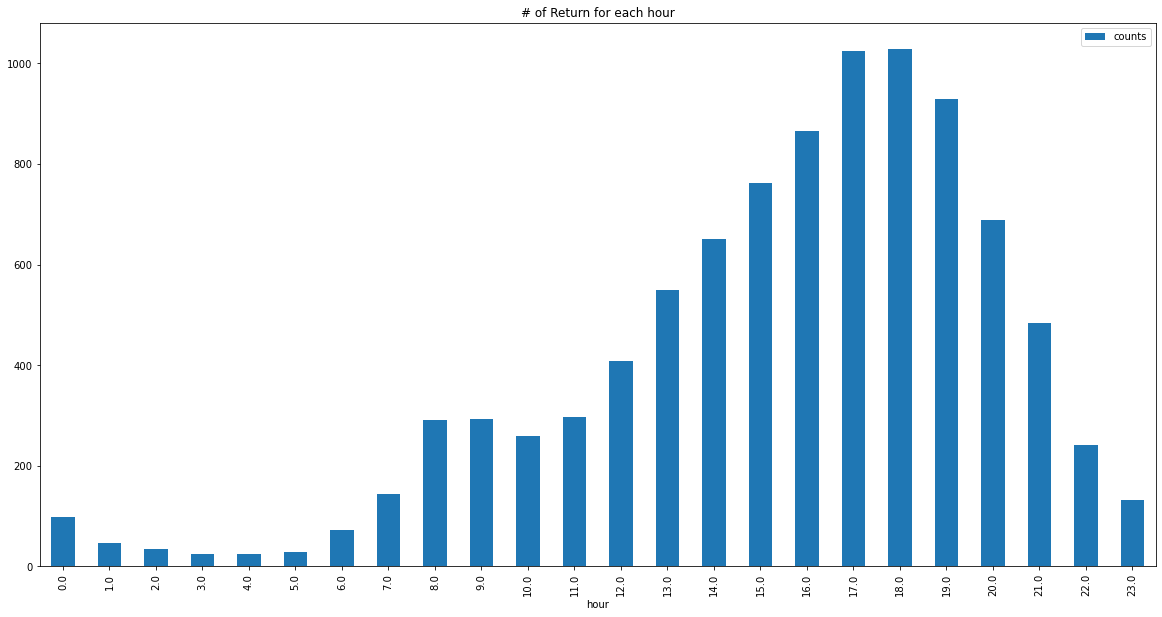

In [63]:
hours = predict_data_return.loc[:, ["hour", "counts"]]
hours["hour"] = (hours["hour"] * 23).round()
hours = hours.groupby("hour").sum()
hours.plot(kind='bar', figsize=(20, 10), title="# of Return for each hour")

In [53]:
# month = predict_data_return.loc[:, ["month", "counts"]]
# month["month"] = (month["month"] * 12).round()
# month = month.groupby("month").sum()
# month.plot(kind='bar', figsize=(20, 10), title="# of Return for each month");

[Text(0.5, 1.0, 'Top 10 return stations')]

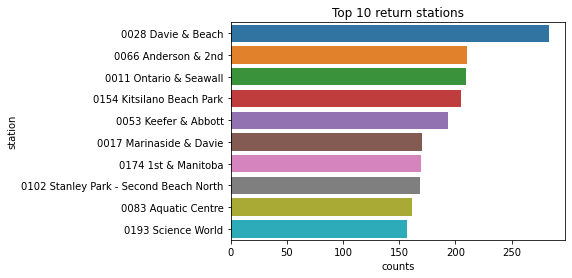

In [65]:
top_stations = predict_data_return[["station", "counts"]].groupby("station").sum().reset_index()
top_stations = top_stations.sort_values(by="counts", ascending= False).head(10)
ax = sns.barplot(x="counts", y="station", data=top_stations)
ax.set(title='Top 10 return stations')

In [68]:
predict_data = predict_data_departure.merge(
    predict_data_return, 
    left_on=['station', "month", "day", "hour"],
    right_on=['station', "month", "day", "hour"])
predict_data["ratio"] = predict_data["counts_x"] / predict_data["counts_y"]
predict_data = predict_data.rename(columns={'lat_x': 'lat', 'long_x': 'long'})
predict_data = predict_data[["lat", "long", "station", "month", "day", "hour", "ratio", "counts_x", "counts_y"]]
predict_data["month"] = (predict_data["month"] * 12).astype(int)
predict_data["day"] = (predict_data["day"] * 31).astype(int)
predict_data["hour"] = (predict_data["hour"] * 23).astype(int)

In [70]:
ratio_data = predict_data.loc[
    (predict_data["ratio"] > 1) & (predict_data["ratio"] < 5) & ((predict_data["counts_x"] > 1) | (predict_data["counts_y"] > 1))].sort_values(by="ratio", ascending=False).head(10)
print(ratio_data)


            lat      long                                      station  month  \
22892  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot      5   
3254   0.693613  0.000447                            0050 Bute & Comox      5   
11273  0.693903  0.000693                         0024 Hornby & Pender      5   
22868  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot      5   
11345  0.693903  0.000693                         0024 Hornby & Pender      5   
17     0.693601  0.000627     0099 Vancouver Art Gallery - North Plaza      5   
22941  0.695631  0.000018  0103 Stanley Park - Third Beach Parking Lot      5   
18     0.693601  0.000627     0099 Vancouver Art Gallery - North Plaza      5   
3206   0.693613  0.000447                            0050 Bute & Comox      5   
11274  0.693903  0.000693                         0024 Hornby & Pender      5   

       day  hour     ratio  counts_x  counts_y  
22892    2    20  4.728086  1.385262  0.292986  
3254     3